# Simulate an FMU with inputs
Tutorial by Tobias Thummerer

🚧 This tutorial is under revision and will be replaced by an up-to-date version soon 🚧

## License

In [1]:
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons, Josef Kircher, Johannes Stoljar
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMI.jl/blob/main/LICENSE) file in the project root for details.

## Introduction to the example
This example shows how to add custom inputs to a FMU, that are used during simulation.

## Other formats
Besides, this [Jupyter Notebook](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/inputs.ipynb) there is also a [Julia file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/inputs.jl) with the same name, which contains only the code cells and for the documentation there is a [Markdown file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/inputs.md) corresponding to the notebook.  

## Code section

In [2]:
# imports
using FMI
using FMIZoo
using Plots
using DifferentialEquations

### Simulation setup

Next, the start time and end time of the simulation are set. Finally, a step size is specified to store the results of the simulation at these time steps.

In [3]:
tStart = 0.0
tStep = 0.01
tStop = 8.0
tSave = tStart:tStep:tStop

0.0:0.01:8.0

### Import FMU

Next, the FMU model from *FMIZoo.jl* is loaded.

In [4]:
# we use an FMU from the FMIZoo.jl
fmu = loadFMU("SpringPendulumExtForce1D", "Dymola", "2022x"; type=:ME) # load FMU in ME-Mode ("Model Exchange")

Model name:	SpringPendulumExtForce1D
Type:		0

#### Simulate as Model-Exchange

In the function `simulate()` the FMU is simulated with an adaptive step size but with fixed save points `tSave`. In addition, the start and end time are specified. Note, that the dynamics of the input variables are not considered by the steps ize control of the solver, so it is highly recommended to limit the solver step size with the keyword argument `dtmax` if the input is more dynamic than the system.

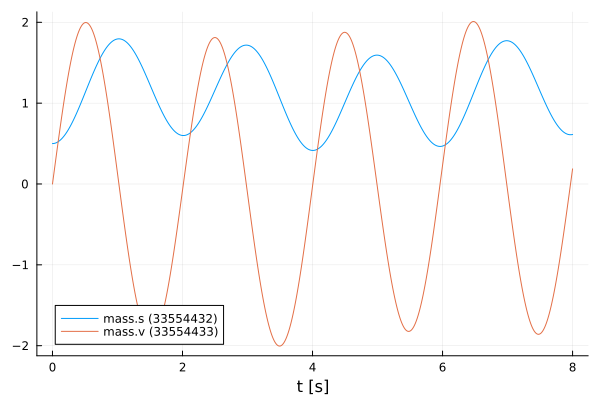

In [5]:
# input function format "t", dependent on `t` (time)
function extForce_t(t::Real, u::AbstractArray{<:Real})
    u[1] = sin(t)
end 

# simulate while setting inputs
data_extForce_t = simulate(fmu, (tStart, tStop);                 # FMU, start and stop time
                          solver = Tsit5(),
                          saveat=tSave,                         # timepoints for the ODE solution to be saved
                          inputValueReferences=["extForce"],    # the value references that should be set (inputs)
                          inputFunction=extForce_t,             # the input function to be used
                          dtmax=1e-2,                           # limit max step size to capture inputs
                          showProgress=false)                   # disable progress bar
plot(data_extForce_t)

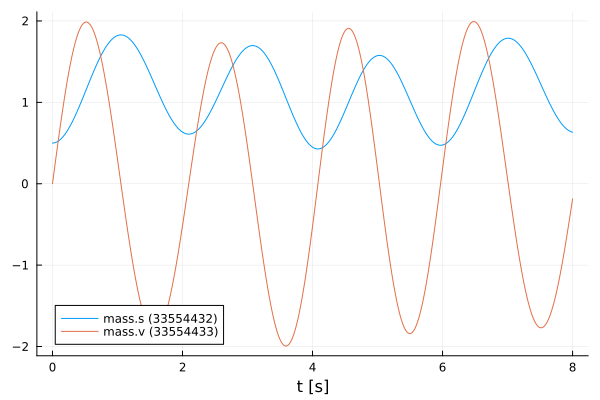

In [6]:
# input function format "cxt", dependent on `c` (component), `x` (state) and `t` (time)
function extForce_cxt(c::Union{FMU2Component, Nothing}, x::Union{AbstractArray{<:Real}, Nothing}, t::Real, u::AbstractArray{<:Real})
    x1 = 0.0
    if x != nothing # this check is important, because inputs may be needed before the system state is known
        x1 = x[1] 
    end
    u[1] = sin(t) * x1
    nothing
end 

# simulate while setting inputs
data_extForce_cxt = simulate(fmu, (tStart, tStop); saveat=tSave, inputValueReferences=["extForce"], inputFunction=extForce_cxt, dtmax=1e-2, showProgress=false)
plot(data_extForce_cxt)

### Unload FMU

After plotting the data, the FMU is unloaded and all unpacked data on disc is removed.

In [7]:
unloadFMU(fmu)